In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
# Analysis parameters
fps = 30.0
max_gap_seconds = 1.0    # time gap beyond which speed is not calculated (in seconds)
smoothing_window = 500  # (in milliseconds)

In [3]:
# Helper functions
def smooth_over_time(df, window_size=0.5):
    """
    This function smooths a timeseries over a fixed time window (seconds)
    
    Parameters
    ----------
    df: DataFrame, shape(n_rows, n_cols)
        dataframe containing columns for the smoothing variable and for time in seconds.
    window_size: int(optional), default = 0.5
        window_size determines the width of the kernel used for smoothing.
        Note: window_size is preferrably odd.
        
    Returns
    -------
    df: DataFrame, shape(n_rows, n_cols+1)
        dataframe with an added column for the smoothed speed
    """
    
    # Use time_s as the index (important for time-based rolling)
    df = df.sort_values('time_s').set_index('time_s')

    # Use a time-based rolling window by converting seconds to timedelta
    df.index = pd.to_timedelta(df.index, unit='s')

    smoothed = df['speed'].rolling(f"{window_size}ms", min_periods=1, center=True).mean()

    df['speed_smoothed'] = smoothed.values
    return df.reset_index(drop=False)

In [4]:
# Load data
df = pd.read_csv('/Volumes/SSD5/20230313/SE_Lek1/P1D1/20230313_SE_Lek1_P1D1_DJI_0294_3D_trajectories_utm.csv')
df = df.loc[:,['frame', 'Point', 'class_id', 'easting', 'northing']]
df.head()

,frame,Point,class_id,easting,northing
0,0,1100001,1.0,444552.385492,3.075119e+06
1,0,1100002,1.0,444588.497858,3.075105e+06
2,0,1100003,0.0,444508.432204,3.075122e+06
3,0,1100004,1.0,444574.869145,3.075144e+06
4,0,1100005,1.0,444550.203567,3.075174e+06


In [5]:
df = df.sort_values(['Point', 'frame']).reset_index(drop=True)

# Calculate individual speeds
# this requires computing the instantaneous displacements of individuals over time (dx)
df[['dx', 'dy']] = df.groupby('Point')[['easting', 'northing']].diff()
df['distance'] = np.sqrt(df['dx'].pow(2) + df['dy'].pow(2))

# and the time difference in which these displacements occurred (dt)
df['frame_diff'] = df.groupby('Point')['frame'].diff()
df['dt_seconds'] = df['frame_diff'] / fps

# speed is distance / dt_seconds
df['speed'] = df['distance'] / df['dt_seconds']

In [6]:
df.loc[df['dt_seconds'] > max_gap_seconds, 'speed'] = np.nan

# convert frame to time in seconds for plotting
df['time_s'] = df['frame'] / fps

df = (
    df.groupby('Point', group_keys=False)
    .apply(lambda s: smooth_over_time(s, smoothing_window))
)

In [7]:
# Consider 'n' individuals with the highest number of rows to plot
n_inds_include = 20

counts = df['Point'].value_counts()    # this function's default behaviour is to sort points by their counts
valid_points = counts.head(n_inds_include).index

min_count_included = counts.head(n_inds_include).min()
print(f"Including top {n_inds_include} Points.")
print(f"Minimum detection count among these = {min_count_included}")

Including top 20 Points.
Minimum detection count among these = 5802


In [8]:
df_plot = df[(df['time_s'] < pd.Timedelta(seconds=15)) & (df['Point'].isin(valid_points))]

# Create a color map for each Point
points = df_plot['Point'].unique()
cmap = plt.colormaps.get_cmap('rainbow')
colors = [cmap(i / len(points)) for i in range(len(points))]
point_color_map = {point: colors[i] for i, point in enumerate(points)}

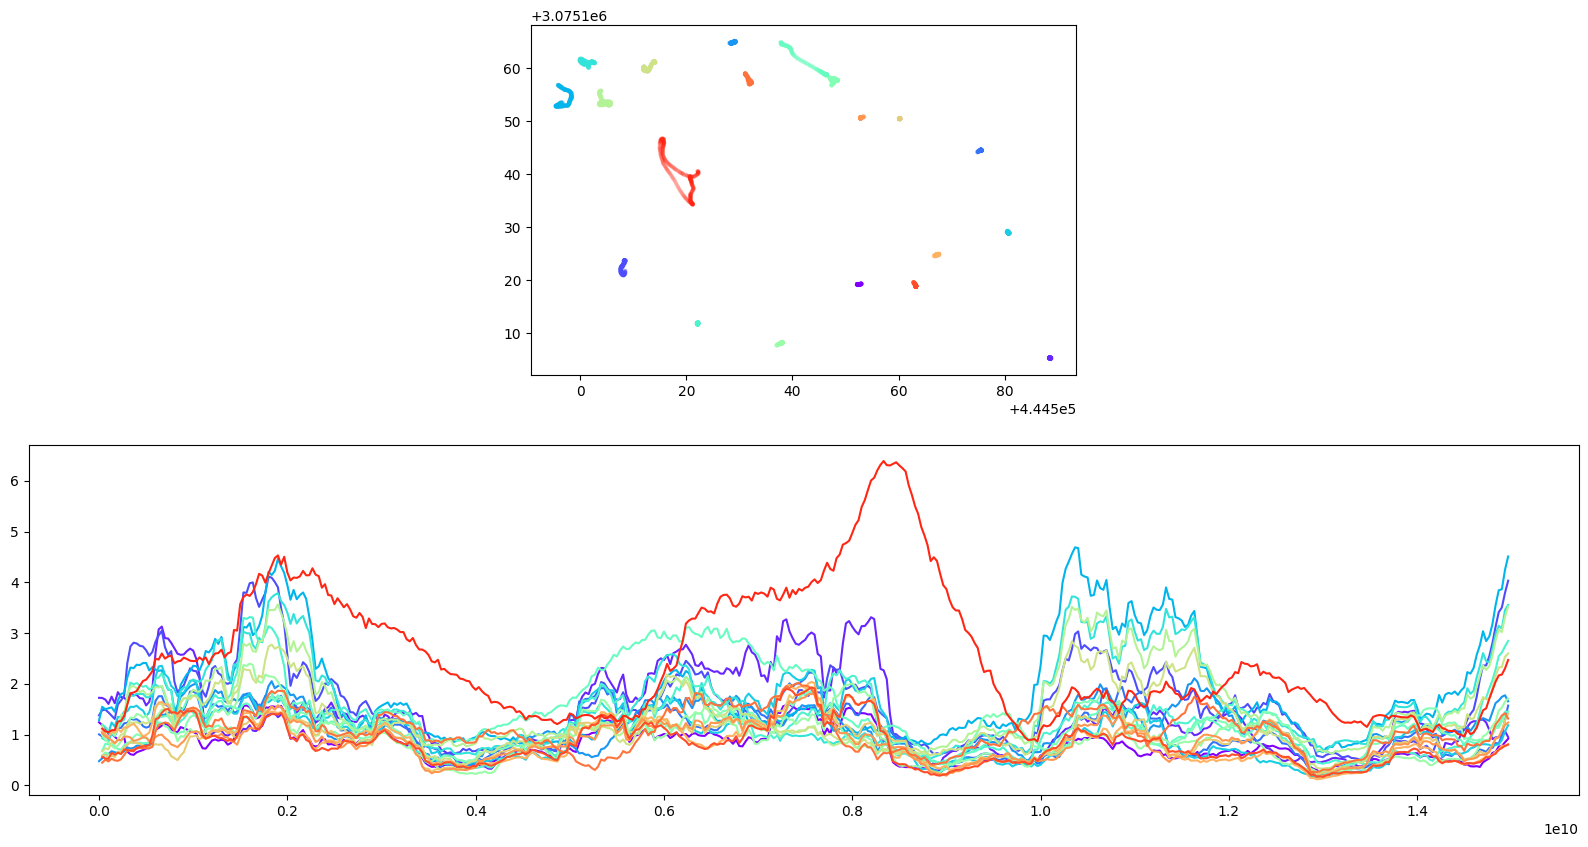

In [9]:
# Plot the trajectories and speed timeseries 
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))

ax1.scatter(df_plot['easting'], df_plot['northing'], c=df_plot['Point'].map(point_color_map), s=5, alpha=0.1)
ax1.set_aspect('equal')

for pt in points:
    df_point = df_plot[df_plot['Point'] == pt]
    ax2.plot(df_point['time_s'], df_point['speed_smoothed'], color=point_color_map[pt])
plt.show()

In [10]:
# Construct a correlation matrix with the speeds
speed_mat = (df[df['Point'].isin(valid_points)]
             .pivot_table(index='frame', columns='Point', values='speed_smoothed').sort_index(axis=1))

corr_mat = speed_mat.corr(method='kendall')
# check the number and effect of nans in the data
# if they're a problem, should one replace them with zeros or the mean value for that column?

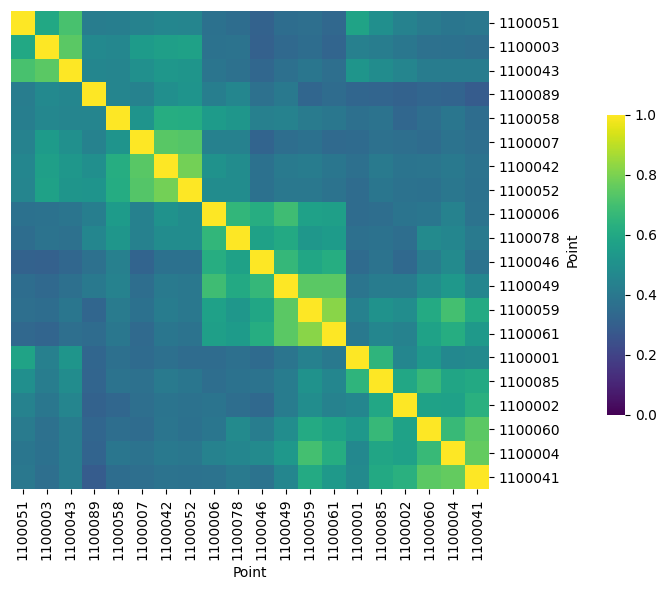

In [11]:
# Plot the correlation matrix
cluster = sns.clustermap(corr_mat, method='average', metric='correlation', cmap='viridis', 
                         vmin=0, vmax=1, dendrogram_ratio=0.001, figsize=(6, 6), cbar_pos=(1.02, 0.3, 0.03, 0.5))

plt.show()